# Ear Verification

In [1]:
from numpy import linalg
from menpo import io as mio
from menpo.visualize import print_dynamic
from sklearn.utils.fixes import bincount
import itertools
import warnings
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from dAAMs.lda import lda, predict, chunk, n_fold_generate
from menpo.feature import igo, hog, no_op, double_igo as digo, dsift, fast_dsift, hellinger_vector_128_dsift, gradient
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from menpo.model import PCAModel, PCAVectorModel
from dAAMs.fisher import FisherVector
import functools

data_cache = {}

%matplotlib inline

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/numpy/core/include', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/include/python3.5m', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/gof', '-L/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib', '-o', '/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']


#### feature extractions

In [2]:
def mod_igos(pixels, double_angles=False):

    if len(pixels.shape) != 3:
        raise ValueError('IGOs only work on 2D images. Expects image data to be 3D, channels + shape.')
                
    n_img_chnls = pixels.shape[0]

    feat_chnls = 2
    if double_angles:
        feat_chnls = 4

    grad = gradient(pixels)
    grad_orient = np.angle(grad[:n_img_chnls] + 1j * grad[n_img_chnls:])

    if double_angles:
        grad_orient = np.hstack([grad_orient, 2*grad_orient])

    return grad_orient


#### classification functions

In [3]:
from dAAMs.lda import lda, predict, chunk, n_fold_generate, decision_function
class LDAWrap:
    def __init__(self):
        self.intercept_ = None
        self.coef_ = None
        self.classes_ = None
    def fit(self,train_X, train_y):
        self.intercept_, self.coef_, self.classes_ = lda(train_X, train_y)
    def predict(self, test_X):
        return predict(test_X, self.intercept_, self.coef_, self.classes_)
    def decision_function(self, test_X):
        return decision_function(test_X,self.intercept_, self.coef_)

In [4]:
class JBC:
    def __init__(self):
        self._A = None
        self._G = None
    def fit(self,train_X, train_y):
        X_I = []
        X_E = []
        for (v1,v2),label in zip(train_X, train_y):
            if label > 0:
                X_I.append(np.concatenate([v1,v2]).reshape(-1,1))
            else:
                X_E.append(np.concatenate([v1,v2]).reshape(-1,1))
                
        print('computing cov Matrixes with size: {} * {}'.format(len(X_I), len(X_I[0])))
        
        covI = np.cov(np.hstack(X_I))
        covE = np.cov(np.hstack(X_E))
        size = covI.shape[0] / 2
        inverseI = np.linalg.inv(covI)
        inverseE = np.linalg.inv(covE)
        
        
        _F = inverseI[0:size,0:size]
        _G = inverseI[0:size,size:]
        _temp = np.zeros(inverseE.shape)
        _temp[0:size,0:size] = _F
        _temp[size:,size:] = _F
        _A = (inverseE - _temp)[0:size,0:size]
        
        self._A = _A
        self._G = _G
        
    def predict(self, test_X):
        return self.decision_function(test_X) > 0
    
    def decision_function(self, test_X):
        def df(self, v1, v2):
            return v1.T.dot(self._A).dot(v1) + v2.T.dot(self._A).dot(v2) - 2 * v1.T.dot(self._G).dot(v2)
        
        return np.array([df(self,v1,v2) for v1,v2 in test_X])
        

#### preprocessing functions

In [5]:
def pair_preprocess_cosine(trains,tests):
    ret_train = []
    ret_test = []
    
    for v1,v2 in trains:
        phi1 = mod_igos(v1)
        phi2 = mod_igos(v2)
        dphi = phi1-phi2
        ret_train.append(np.mean(np.cos(dphi)))
        
    for v1,v2 in tests:
        phi1 = mod_igos(v1)
        phi2 = mod_igos(v2)
        dphi = phi1-phi2
        ret_test.append(np.mean(np.cos(dphi)))
        
    return ret_train, ret_test

In [6]:
def pair_preprocess_concat(trains,tests):
    ret_train = []
    ret_test = []
    
    for v1,v2 in trains:
        ret_train.append(np.concatenate([v1,v2]))
        
    for v1,v2 in tests:
        ret_test.append(np.concatenate([v1,v2]))
        
    return ret_train, ret_test

In [7]:
def pair_preprocess_diff(trains,tests):
    ret_train = []
    ret_test = []
    
    for v1,v2 in trains:
        ret_train.append(v1-v2)
        
    for v1,v2 in tests:
        ret_test.append(v1-v2)
        
    return ret_train, ret_test

In [8]:
def pair_preprocess_l2norm(trains,tests):
    ret_train = []
    ret_test = []
    
    for v1,v2 in trains:
        ret_train.append(np.linalg.norm(v1-v2))
        
    for v1,v2 in tests:
        ret_test.append(np.linalg.norm(v1-v2))
        
    return ret_train, ret_test

In [9]:
import numpy as np
from sklearn.decomposition import PCA
def pair_preprocess_pca(trains,tests, ratio=0.9):
    ret_train = []
    ret_test = []
    
    tr1,tr2 = list(zip(*trains))
    t1,t2 = list(zip(*tests))
      
    pca = PCAVectorModel(tr1 + tr2)
    
    if ratio < 1:
        n_active_component = np.argwhere(pca.eigenvalues_cumulative_ratio() > ratio)[0][0]
    else:
        n_active_component = ratio
    
    pca.n_active_components = n_active_component
    
    
    ret_train,ret_test = list(zip([pca.project(vec) for vec in tr1],[pca.project(vec) for vec in tr2])),list(zip([pca.project(vec) for vec in t1],[pca.project(vec) for vec in t2]))
    
    return ret_train, ret_test

In [10]:
def pair_preprocess_fv(trains,tests, K=128):
    ret_train = []
    ret_test = []
    
    tr1,tr2 = list(zip(*trains))
    t1,t2 = list(zip(*tests))
    
    fv = FisherVector(tr1+tr2, K=K)
    
    ret_train,ret_test = list(zip([fv.generate(vec, normalise=True) for vec in tr1],[fv.generate(vec, normalise=True) for vec in tr2])),list(zip([fv.generate(vec, normalise=True) for vec in t1],[fv.generate(vec, normalise=True) for vec in t2]))
    
    return ret_train, ret_test

In [11]:
def pair_preprocess_fv_all(trains,tests, K=128):
    ret_train = []
    ret_test = []
    
    tr1,tr2 = list(zip(*trains))
    t1,t2 = list(zip(*tests))
    
    fv = FisherVector(tr1+tr2, K=K)
    
    ret_train,ret_test = [fv.generate([v1,v2], normalise=True) for v1,v2 in trains],[fv.generate([v1,v2], normalise=True) for v1,v2 in tests]
    
    return ret_train, ret_test

In [12]:
def pair_preprocess_fv_l2norm(trains,tests, K=128):
    ret_train = []
    ret_test = []
    
    tr1,tr2 = list(zip(*trains))
    t1,t2 = list(zip(*tests))
    
    fv = FisherVector(tr1+tr2, K=K)
    
    ret_train,ret_test = [np.linalg.norm(fv.generate([v1,v2], normalise=True)) for v1,v2 in trains],[np.linalg.norm(fv.generate([v1,v2], normalise=True)) for v1,v2 in tests]
    
    return ret_train, ret_test

In [13]:
def pair_preprocess_pca_fv_all(trains,tests, ratio=0.9, K=128):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    return pair_preprocess_fv_all(ret_train, ret_test, K=K)

In [14]:
def pair_preprocess_pca_fv_all_l2norm(trains,tests, ratio=0.9, K=128):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    return pair_preprocess_fv_l2norm(ret_train, ret_test, K=K)

In [15]:
def pair_preprocess_pca_fv_l2norm(trains,tests, ratio=0.9, K=128):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    ret_train, ret_test = pair_preprocess_fv(ret_train, ret_test, K=K)
    return pair_preprocess_l2norm(ret_train, ret_test)

In [16]:
def pair_preprocess_pca_concat(trains,tests, ratio=0.9):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    return pair_preprocess_concat(ret_train, ret_test)

In [17]:
def pair_preprocess_pca_l2norm(trains,tests, ratio=0.9):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    return pair_preprocess_l2norm(ret_train, ret_test)

In [18]:
def pair_preprocess_pca_diff(trains,tests, ratio=0.9):
    ret_train, ret_test = pair_preprocess_pca(trains,tests, ratio)
    return pair_preprocess_diff(ret_train, ret_test)

In [19]:
def pair_preprocess_concat_pca(trains,tests, ratio=0.9):
    ret_train = []
    ret_test = []
    
    for v1,v2 in trains:
        ret_train.append(np.concatenate([v1,v2]))
        
    for v1,v2 in tests:
        ret_test.append(np.concatenate([v1,v2]))
        
    
    pca = PCAVectorModel(ret_train)
    pca.n_active_components = np.argwhere(pca.eigenvalues_cumulative_ratio() > ratio)[0][0]
    
    ret_train,ret_test = [pca.project(vec) for vec in ret_train],[pca.project(vec) for vec in ret_test]
        
    return ret_train, ret_test

### load model

In [20]:
def validation(folds, index, clf, postfix='', preprocess=None):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    
    for i,f in enumerate(folds):
        if not i == index:
            pairs,labels = list(zip(*f))
            train_X += list(pairs)
            train_y += labels
        else:
            pairs,labels = list(zip(*f))
            test_X += list(pairs)
            test_y += labels
            
            
    def query_data(fname):
        if not fname in data_cache.keys():
            img = mio.import_pickle(fname) if fname.suffix == '.pkl' else mio.import_image(fname).pixels.ravel()
            data_cache[fname] = img

        return fname

    for index, (fname1,fname2) in enumerate(train_X):
        train_X[index] = [data_cache[query_data(fname1)], data_cache[query_data(fname2)]]

    for index, (fname1,fname2) in enumerate(test_X):
        test_X[index] = [data_cache[query_data(fname1)], data_cache[query_data(fname2)]]
        
    if preprocess:
        train_X, test_X = preprocess(train_X, test_X)

    train_X = np.array(train_X).astype(float)
    test_X = np.array(test_X).astype(float)
    
    if len(train_X.shape) == 1:
        train_X = train_X.reshape((train_X.shape)+(1,))
    if len(test_X.shape) == 1:  
        test_X = test_X.reshape((test_X.shape)+(1,))
    
    train_y = np.array(train_y).astype(int)
    test_y = np.array(test_y).astype(int)
    
    
    
    clf.fit(train_X,train_y)

    py = clf.predict(test_X)
    
    
    acc = accuracy_score(test_y, py)
    
    try:
        fpr, tpr, _ = roc_curve(test_y, clf.decision_function(test_X), pos_label=1)
        roc_auc = auc(fpr, tpr)
    except Exception as e:
        print(e)
        fpr, tpr, roc_auc = [0,0,0]

    
    
    print(acc)
    return acc, fpr, tpr, roc_auc, clf

In [21]:
def intersect_validation(folds_A,folds_B, index, clf, postfix='', preprocess=None):
    intersect_A = [folds_B[index]] + [f for i,f in enumerate(folds_A) if not i == index ]
    intersect_B = [folds_A[index]] + [f for i,f in enumerate(folds_B) if not i == index ]
    return validation(intersect_A, 0, clf,postfix=postfix,preprocess=preprocess),validation(intersect_B, 0, clf,postfix=postfix,preprocess=preprocess)

In [22]:
def cross_intersect_validation(folds_A,folds_B, clf, postfix='', preprocess=None):
    results = []
    for i in range(len(folds_A)):
        results.append(intersect_validation(folds_A,folds_B, i, clf,postfix=postfix,preprocess=preprocess))
        
    return results

In [23]:
def cross_validation(folds, clf, postfix='', preprocess=None):
    results = []
    for i in range(len(folds)):
        results.append(validation(folds, i, clf,postfix=postfix,preprocess=preprocess))
        
    return results

In [24]:
def fold_norm(foldA, foldB):
    N_pairs_A = len(foldA[0])
    N_pairs_B = len(foldB[0])
    max_fold_pairs = np.min([N_pairs_A,N_pairs_B])
    shuffle_A = list(range(N_pairs_A))
    shuffle_B = list(range(N_pairs_B))
    np.random.shuffle(shuffle_A)
    np.random.shuffle(shuffle_B)
    shuffle_A = shuffle_A[:max_fold_pairs]
    shuffle_B = shuffle_B[:max_fold_pairs]
    
    return [list(np.array(foldA[0])[shuffle_A]),list(np.array(foldA[1])[shuffle_A])],[list(np.array(foldB[0])[shuffle_B]),list(np.array(foldB[1])[shuffle_B])]
    


In [25]:
def protocalAndPath(protocol, db_path, ext):
    db_path = Path(db_path)
    ret_protocol = []
    
    for fold in protocol:
        ret_fold = []
        for index, ((p1,p2), label) in enumerate(fold):
            ret_fold.append([[Path('{}/{}{}'.format(db_path,Path(p1).stem,ext)),Path('{}/{}{}'.format(db_path,Path(p2).stem,ext))],label])
        ret_protocol.append(ret_fold)

    return ret_protocol

In [26]:
from menpo.visualize import plot_curve
def roc_plot(methods_results, 
             legend_names=[], 
             bbox_to_anchor=(1.3, 0.5), 
             figsize=(5,7), 
             line_width=5,
             render_legend=True,
             font_size=10,
             legend_n_columns=1,
             line_style='-'
            ):
#     plt.figure(figsize=figsize)


    cm = plt.get_cmap('jet')
    n_colours = len(methods_results)
    colours = [cm(1.*i/n_colours)[:3] for i in range(n_colours)]

    num_folds = len(methods_results[0])

    for method_id,results in enumerate(methods_results):

        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)

        for r in results:
            mean_tpr += np.interp(mean_fpr, r[1], r[2])
            mean_tpr[0] = 0.0

        mean_tpr /= num_folds
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        #         plt.plot(mean_fpr, mean_tpr, '--', lw=3)
        #         plot_curve(mean_fpr,mean_tpr)
#         plot settings
        if len(legend_names):
            legend_entries = [legend_names[method_id]]
        else:
            legend_entries = None
        
        plot_curve(
            mean_fpr, mean_tpr, new_figure=False, 
            legend_entries=legend_entries, 
            title='ROC curve', x_label='False positive Rate (FPR)', y_label='True positive rate (TPR)',
            axes_x_ticks = np.arange(0,1,0.1), axes_y_ticks=np.arange(0,1,0.1),
            render_markers=False,
            line_width=line_width, line_style=line_style, line_colour=colours[method_id],
            legend_bbox_to_anchor=bbox_to_anchor, legend_location=10, render_legend=render_legend,
            figure_size=figsize, legend_font_size=font_size, axes_font_size=font_size,
            legend_n_columns=legend_n_columns
        )

        if len(legend_names):
            print('{:} Auc: {:5.3f}, Mean: {:6.4f}, Std: {:5.3f}'.format(legend_names[method_id], mean_auc, np.mean([r[0] for r in results]), np.std([r[0] for r in results])))
        

#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.ylabel('True positive rate (TPR)')
#     plt.xlabel('False positive Rate (FPR)')
#     plt.title('ROC curve')
#     plt.tick_params(labelsize=14)

#     if len(legend_names):
#         plt.legend(legend_names, loc=10, bbox_to_anchor=bbox_to_anchor)
        
#     plt.show()

## Experiments

In [27]:
db_path = Path('/homes/yz4009/wd/databases/ear/EarVerification/')
db_type = "bound"
# db_type = "aligned"

feature = ''
ext = '+{}.pkl'.format(feature) if not feature == '' else '.jpg'
# preprocess = functools.partial(pair_preprocess_pca, ratio=32)
preprocess = pair_preprocess_l2norm
# preprocess = pair_preprocess_pca
# preprocess = None

In [28]:
# clf = JBC()
# clf = svm.SVC(C=125)
clf = LinearDiscriminantAnalysis()

#### VGGEAR

In [29]:
protocol_vggear = mio.import_pickle('{}/{}/protocol.pkl'.format(db_path,'VGGEAR'), encoding='latin1')

In [30]:
Bd = cross_validation(protocalAndPath(protocol_vggear, db_path/'VGGEAR'/db_type,ext), clf, postfix=feature, preprocess=preprocess)
print('Mean acc: {}'.format(np.mean(list(zip(*Bd))[0])))

0.602702702703
0.564864864865
0.578378378378
0.521621621622
0.562162162162
Mean acc: 0.5659459459459459


#### WPUTEDB

In [31]:
protocol_wputedb = mio.import_pickle('{}/{}/protocol.pkl'.format(db_path,'WPUTEDB'), encoding='latin1')

In [32]:
Ad = cross_validation(protocalAndPath(protocol_wputedb, db_path/'WPUTEDB'/db_type,ext), clf, postfix=feature, preprocess=preprocess)
print('Mean acc: {}'.format(np.mean(list(zip(*Ad))[0])))

0.667567567568
0.691891891892
0.594594594595
0.605405405405
0.672972972973
Mean acc: 0.6464864864864865


#### Cross Test

In [33]:
civ_result = cross_intersect_validation(protocalAndPath(protocol_wputedb, db_path/'WPUTEDB'/db_type,ext),protocalAndPath(protocol_vggear, db_path/'VGGEAR'/db_type,ext), clf, postfix=feature, preprocess=preprocess)

0.548648648649
0.548648648649
0.540540540541
0.610810810811
0.559459459459
0.527027027027
0.548648648649
0.597297297297
0.548648648649
0.57027027027


In [34]:
Ac,Bc = list(zip(*civ_result))
print('Mean acc Ac: {}'.format(np.mean(list(zip(*Ac))[0])))
print('Mean acc Bc: {}'.format(np.mean(list(zip(*Bc))[0])))

Mean acc Ac: 0.5491891891891891
Mean acc Bc: 0.5708108108108109


In [35]:
adv = np.mean(list(zip(*Ad))[0])
bdv = np.mean(list(zip(*Bd))[0])
acv = np.mean(list(zip(*Ac))[0])
bcv = np.mean(list(zip(*Bc))[0])

print([adv,acv,bdv,bcv,bcv-bdv,adv-acv])

[0.64648648648648654, 0.54918918918918913, 0.56594594594594594, 0.57081081081081086, 0.0048648648648649262, 0.097297297297297414]


#### store results

In [36]:
mio.export_pickle([Ad,Ac,Bd,Bc], '/homes/yz4009/wd/PickleModel/EarRecognition/verification_unaligned_PI_LDA.pkl', overwrite=False)

## Visualise Results

In [ ]:
[Ad,Ac,Bd,Bc] = mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/verification_unaligned_DSIFT_SVM.pkl')

WPUTEDB+Direct+PI Auc: 0.730, Mean: 0.6465, Std: 0.039
WPUTEDB+Cross+PI Auc: 0.595, Mean: 0.5492, Std: 0.006
Our DB+Direct+PI Auc: 0.595, Mean: 0.5659, Std: 0.026
Our DB+Cross+PI Auc: 0.730, Mean: 0.5708, Std: 0.031


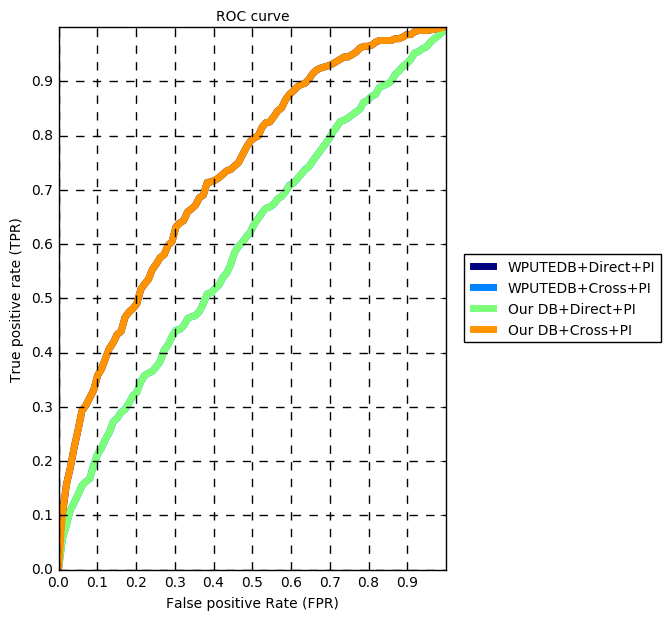

In [45]:
roc_plot([Ad, Ac, Bd, Bc], ['WPUTEDB+Direct+PI', 'WPUTEDB+Cross+PI', 'Our DB+Direct+PI', 'Our DB+Cross+PI'])

## Report Verification Comparision

In [56]:
results_compare_aligned = []
results_compare_aligned_labels = []
for method in ['SVM']:
    for feature in ['PI']:
        results_compare_aligned.append(
            mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/verification_aligned_{}_{}.pkl'.format(feature, method))
        )
        results_compare_aligned_labels.append([
            'W+Inter+{}+{}'.format(feature, 'LDA'), 
            'W+Intra+{}+{}'.format(feature, 'LDA'), 
            'Our DB+Inter+{}+{}'.format(feature, 'LDA'), 
            'Our DB+Intra+{}+{}'.format(feature, 'LDA')
        ])
        
results_compare_aligned = np.concatenate(results_compare_aligned)
results_compare_aligned_labels = np.concatenate(results_compare_aligned_labels)

W+Inter+PI+LDA Auc: 0.705, Mean: 0.6573, Std: 0.050
W+Intra+PI+LDA Auc: 0.576, Mean: 0.5724, Std: 0.020
Our DB+Inter+PI+LDA Auc: 0.587, Mean: 0.5568, Std: 0.007
Our DB+Intra+PI+LDA Auc: 0.692, Mean: 0.6476, Std: 0.043


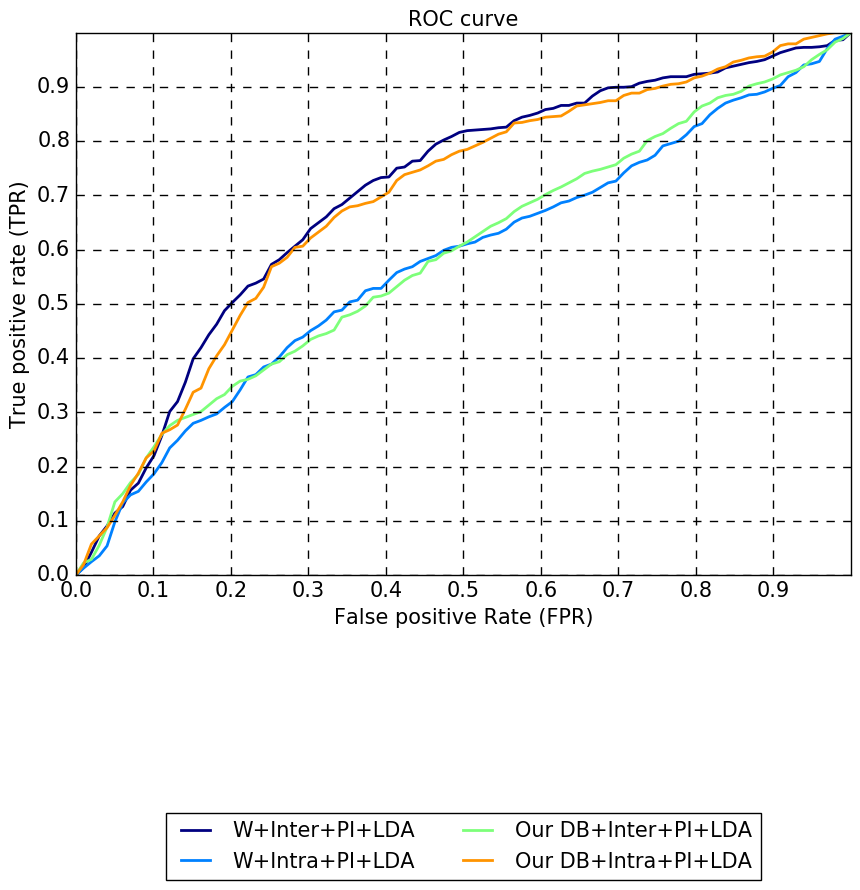

In [57]:
roc_plot(results_compare_aligned, results_compare_aligned_labels, 
         bbox_to_anchor=(0.5, -0.5), line_width=2, render_legend=True, legend_n_columns=2,
         font_size=15, figsize=(10, 7)
        )

In [ ]:
%debug

In [ ]:
results = {
    'SVM+int': [0.62702702702702706, 0.54864864864864871, 0.52702702702702697, 0.59999999999999998, 0.072972972972973005, 0.078378378378378355],
    'LDA+int': [0.64648648648648654, 0.54918918918918913, 0.56594594594594594, 0.57081081081081086, 0.0048648648648649262, 0.097297297297297414],
#     'SVM+igo':[0.62046649888935368, 0.58349243135459317, 0.6123870687392875, 0.52932042172716209, -0.083066647012125405, 0.036974067534760513],
#     'LDA+igo':[0.62667534650736612, 0.56914678977656408, 0.6176923032157684, 0.5676226300631031, -0.050069673152665306, 0.057528556730802038],
    'LDA+int+align':[0.67675675675675673, 0.57729729729729728, 0.56054054054054059, 0.65621621621621617, 0.095675675675675587, 0.099459459459459443],
    'SVM+int+align':[0.65729729729729724, 0.57243243243243236, 0.55675675675675684, 0.64756756756756739, 0.090810810810810549, 0.084864864864864886],
#     'SVM+dsift+align':[0.50148215499417503, 0.49853543197716998, 0.50658903452281734, 0.51758557246870907, 0.010996537945891727, 0.0029467230170050485],
#     'LDA+dsift+align':[0.68480749310169531, 0.58961469083626228, 0.65152646116141866, 0.55939885707195658, -0.092127604089462078, 0.09519280226543303],
#     'LDA+dsift': [0.7005405405405406, 0.58918918918918917, 0.62594594594594599, 0.54162162162162164, -0.084324324324324351, 0.11135135135135144],
    'LDA+PEP+PCA+align': [0.64540540540540536, 0.58648648648648638, 0.61891891891891893, 0.63729729729729734, 0.018378378378378413, 0.058918918918918983],
    'SVM+PEP+PCA+align': [0.62378378378378374, 0.55459459459459448, 0.60918918918918918, 0.58756756756756756, -0.021621621621621623, 0.06918918918918926],
#     'SVM+dsiff': [0.5077264120799666, 0.50158446895955011, 0.49502824983447358, 0.49941304347826082, 0.0043847936437872437, 0.0061419431204164932],
    'LDA+PEP+align': [0.65405405405405403, 0.58864864864864852, 0.62216216216216214, 0.63891891891891883, 0.016756756756756697, 0.065405405405405515],
    'SVM+PEP+align':[0.63891891891891883, 0.5637837837837838, 0.60324324324324319, 0.58108108108108103, -0.022162162162162158, 0.075135135135135034],
}

In [ ]:
key_len = 18
print(' method             &   Ad  &   Ac  &   Bd  &   Bc  &  Bc-Bd &  Ad-Ac \\\\')
for k in results.keys():
    res = results[k]
#     print(' {} & {:4.1f}% & {:4.1f}% & {:4.1f}% & {:4.1f}% & {:5.1f}% & {:5.1f}% \\\\'.format(k + ' '*(key_len-len(k)),res[0]*100.0,res[1]*100.0,res[2]*100.0,res[3]*100.0,res[4]*100.0,res[5]*100.0))
    print(' {} & {:6.4f} & {:6.4f} & {:6.4f} & {:6.4f} & {:7.4f} & {:7.4f} \\\\'.format(k + ' '*(key_len-len(k)),res[0],res[1],res[2],res[3],res[4],res[5]))

## Report Verification Benchmark

In [132]:
alignment = 'unalign'
results_compare_aligned = []
results_compare_aligned_labels = ['PI', 'DSIFT', 'DEEP', 'EigenPEP']
method_label = ['PI','DSIFT','PEP','FV']
for method in method_label:
    results_compare_aligned.append([
        mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/verification_bench_{}_{}.pkl'.format(alignment,method))
    ])
        
results_compare_aligned = np.concatenate(results_compare_aligned)

PI Auc: 0.549, Mean: 0.5405, Std: 0.023
DSIFT Auc: 0.686, Mean: 0.6178, Std: 0.025
DEEP Auc: 0.773, Mean: 0.6492, Std: 0.032
EigenPEP Auc: 0.695, Mean: 0.6189, Std: 0.023


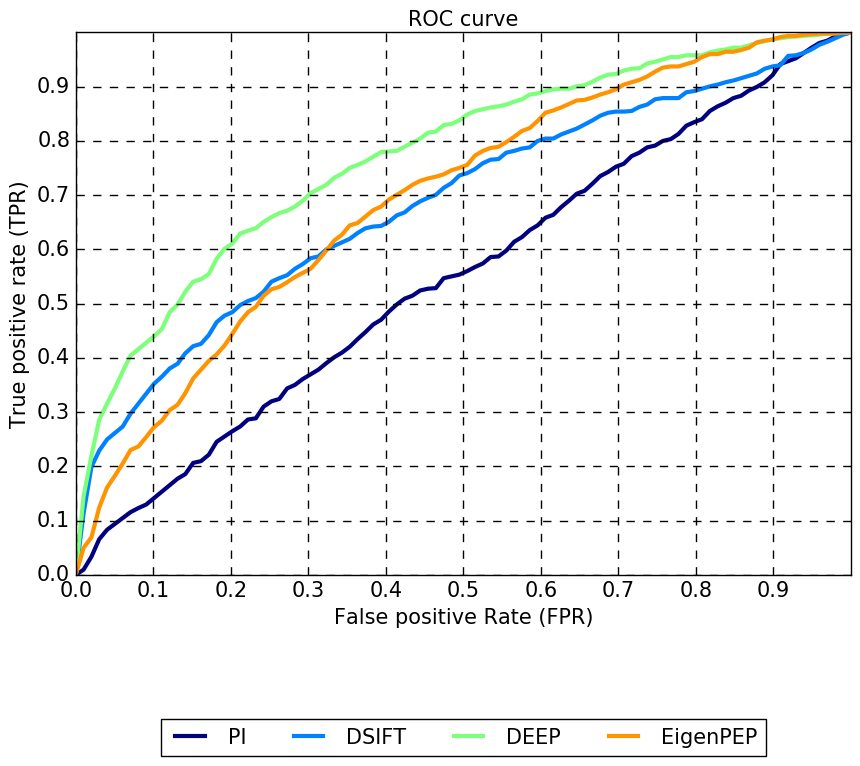

In [133]:
roc_plot(results_compare_aligned, results_compare_aligned_labels, bbox_to_anchor=(0.5, -0.3), line_width=3,
         font_size=15, figsize=(10,7), render_legend=True, legend_n_columns = 4
        )

In [33]:
%debug

> <ipython-input-1-9336f85e0926>(7)<module>()
      5 for method in method_label:
      6     results_compare_aligned.append([
----> 7         mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/verification_bench_{}_{}.pkl'.format(alignment,method))
      8     ])
      9 

ipdb> c


In [ ]:
np.array([1,2]).dot(np.array([3,4]))

In [22]:
import numpy as np
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 41, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [24]:
np.random.rand()

0.20238856852932796

In [65]:
import menpo.io as mio
from pathlib import Path
from menpo.visualize import print_progress
from menpowidgets import visualize_images
import os
%matplotlib inline

### Collection A

In [36]:
db_path = '/homes/yz4009/wd/databases/ear/600EITW/all'
exp_path = Path('/vol/atlas/databases/ear/600EITW')

images = mio.import_images(db_path)


for i,img in enumerate(print_progress(images)): 
    fdir = 'train' if i < 500 else 'test'
    index = i if i < 500 else i - 500
    name = '%s_%04d'%(fdir,index)
        
    mio.export_image(img, exp_path/fdir/('%s.png'%name), overwrite=True)
    mio.export_landmark_file(img.landmarks['PTS'], exp_path/fdir/('%s.pts'%name), overwrite=True)

### Collection B

In [68]:
db_path = Path('/homes/yz4009/wd/databases/ear/VGGEers-Recognition/')
exp_path = Path('/vol/atlas/databases/ear/IBUGEARS/CollectionB/')

In [70]:
for p_dir in print_progress(list(db_path.glob('*'))):
    if p_dir.is_dir():
        dir_name = p_dir.name
        images = mio.import_images(p_dir)
        
        for i,img in enumerate(images): 
            
            if not os.path.exists(str(exp_path/dir_name)):
                os.mkdir(str(exp_path/dir_name))
            
            img.landmarks['bb'] = img.landmarks['PTS'].lms.bounding_box()
            mio.export_image(img, exp_path/dir_name/('%04d.png'%i), overwrite=True)
            mio.export_landmark_file(img.landmarks['bb'], exp_path/dir_name/('%04d.pts'%i), overwrite=True)

[====================] 100% (232/232) - done.                                   
